# CNN su MNIST
**Purpose**: train a **Convolutional Neural Network** on **MNIST** dataset.

## Contents
1. Dataset & Preview
2. Utility Functions (im2col, base functions)
3. Layers (Conv, ReLU, MaxPool, Flatten, Dense)
4. Model + Forward/Backward
5. Training loop (SGD)
6. Loss/Accuracy
7. Evaluation & Examples of Prediction

## 1) Dataset & Preview

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28, 1) (60000,) | Test: (10000, 28, 28, 1) (10000,)


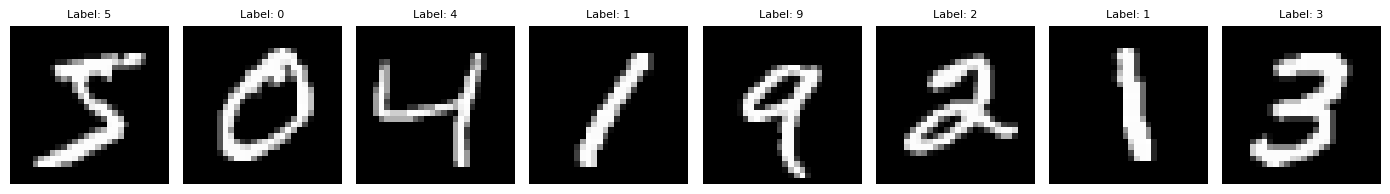

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = (x_train.astype(np.float32) / 255.0)[..., None]
x_test  = (x_test.astype(np.float32) / 255.0)[..., None]
y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

print("Train:", x_train.shape, y_train.shape, "| Test:", x_test.shape, y_test.shape)

# Preview
fig, ax = plt.subplots(1, 8, figsize=(14,2))
for i in range(8):
    ax[i].imshow(x_train[i].squeeze(), cmap='gray')
    ax[i].set_title(f"Label: {y_train[i]}", fontsize=8)
    ax[i].axis('off')
plt.tight_layout(); plt.show()


## 2) Utility Functions (im2col, col2im, softmax, loss)

In [3]:

# Padding 2D
def pad2d(x, pad):
    if pad == 0:
        return x
    return np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant')

# im2col/col2im for conv 2D (stride=1)
# Convert sliding image blocks into columns for fast convolution via GEMM.
def im2col(x, kH, kW, stride=1, pad=0):
    N, H, W, C = x.shape
    xp = pad2d(x, pad)
    Hp, Wp = xp.shape[1], xp.shape[2]
    out_h = (Hp - kH)//stride + 1
    out_w = (Wp - kW)//stride + 1
    cols = np.zeros((N, out_h, out_w, kH, kW, C), dtype=x.dtype)
    for i in range(out_h):
        for j in range(out_w):
            cols[:, i, j, :, :, :] = xp[:, i*stride:i*stride+kH, j*stride:j*stride+kW, :]
    return cols.reshape(N*out_h*out_w, kH*kW*C), out_h, out_w

# Inverse of im2col: fold columns back to the original image tensor.
def col2im(cols, x_shape, kH, kW, out_h, out_w, stride=1, pad=0):
    N, H, W, C = x_shape
    xp = np.zeros((N, H+2*pad, W+2*pad, C), dtype=cols.dtype)
    cols_r = cols.reshape(N, out_h, out_w, kH, kW, C)
    for i in range(out_h):
        for j in range(out_w):
            xp[:, i*stride:i*stride+kH, j*stride:j*stride+kW, :] += cols_r[:, i, j, :, :, :]
    return xp[:, pad:-pad, pad:-pad, :] if pad>0 else xp

# Softmax & Cross-Entropy
def softmax(z):
    z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def cross_entropy(p, y):
    N = y.shape[0]
    q = p[np.arange(N), y].clip(1e-12, 1.0)
    return -np.mean(np.log(q))

# Gradient of (softmax + cross-entropy)
def softmax_ce_backward(p, y):
    N = y.shape[0]
    g = p.copy()
    g[np.arange(N), y] -= 1.0
    return g / N

def accuracy(p, y):
    return (p.argmax(axis=1) == y).mean()


## 3) Layers

In [4]:

# He initialization of weights (for networks using ReLU)
def he_init(shape, fan_in):
    return np.random.randn(*shape) * np.sqrt(2.0 / fan_in)

# 2D convolution implemented via im2col + Matrix Multiplication
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size=3, pad='same'):
        self.k = kernel_size
        self.pad = (self.k // 2) if pad == 'same' else 0
        # Weights (kH, kW, Cin, Cout)
        fan_in = self.k * self.k * in_channels
        self.W = he_init((self.k, self.k, in_channels, out_channels), fan_in).astype(np.float32)
        self.b = np.zeros(out_channels, dtype=np.float32)
        self.cache = None

    def forward(self, x):
        cols, out_h, out_w = im2col(x, self.k, self.k, stride=1, pad=self.pad)
        Wc = self.W.reshape(-1, self.b.shape[0])
        out = cols @ Wc + self.b
        out = out.reshape(x.shape[0], out_h, out_w, self.b.shape[0])
        self.cache = (x, cols, out_h, out_w, Wc)
        return out

    def backward(self, dout, lr):
        x, cols, out_h, out_w, Wc = self.cache
        dout_r = dout.reshape(-1, self.b.shape[0])
        dW = (cols.T @ dout_r).reshape(self.W.shape)
        db = dout_r.sum(axis=0)
        dcols = dout_r @ Wc.T
        dx = col2im(dcols, x.shape, self.k, self.k, out_h, out_w, stride=1, pad=self.pad)
        # SGD
        self.W -= lr * dW
        self.b -= lr * db
        return dx

class ReLU:
    def __init__(self): self.mask=None
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask
    def backward(self, dout, lr):
        return dout * self.mask

# Max pooling with 2x2 windows and stride=2
class MaxPool2x2:
    def __init__(self):
        self.cache=None
    def forward(self, x):
        N,H,W,C = x.shape
        assert H % 2 == 0 and W % 2 == 0, "MaxPool2x2 needs H and W even"
        oh, ow = H//2, W//2
        xr = x.reshape(N, oh, 2, ow, 2, C)
        out = xr.max(axis=(2,4))
        self.cache = (x, xr, out, oh, ow)
        return out
    def backward(self, dout, lr):
        x, xr, out, oh, ow = self.cache
        mask = (xr == out[:, :, None, :, None, :])
        dxr = mask.astype(dout.dtype) * dout[:, :, None, :, None, :]
        return dxr.reshape(x.shape)

# Reshape feature maps into a 2D (N, D) matrix.
class Flatten:
    def __init__(self): self.orig=None
    def forward(self, x):
        self.orig = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, dout, lr):
        return dout.reshape(self.orig)

# Fully-connected layer (linear transformation): y = xW + b
class Dense:
    def __init__(self, in_dim, out_dim):
        self.W = he_init((in_dim, out_dim), in_dim).astype(np.float32)
        self.b = np.zeros(out_dim, dtype=np.float32)
        self.cache = None
    def forward(self, x):
        self.cache = x
        return x @ self.W + self.b
    def backward(self, dout, lr):
        x = self.cache
        dW = x.T @ dout
        db = dout.sum(axis=0)
        dx = dout @ self.W.T
        # SGD
        self.W -= lr * dW
        self.b -= lr * db
        return dx


## 4) Model + Forward/Backward

In [5]:

# Architecture:
#   Conv(8, 3x3, same) -> ReLU -> MaxPool2x2
#   Conv(16, 3x3, same) -> ReLU -> MaxPool2x2
#   Flatten -> Dense(64) -> ReLU -> Dense(10) -> Softmax

C = x_train.shape[3]  # 1 channel for MNIST (grayscale)

conv1 = Conv2D(in_channels=C, out_channels=8, kernel_size=3, pad='same')
relu1 = ReLU()
pool1 = MaxPool2x2()

conv2 = Conv2D(in_channels=8, out_channels=16, kernel_size=3, pad='same')
relu2 = ReLU()
pool2 = MaxPool2x2()

flat = Flatten()
dense1 = Dense(in_dim=16*(28//4)*(28//4), out_dim=64)
relu3 = ReLU()
dense2 = Dense(in_dim=64, out_dim=10)

# Forward pass through the entire network up to logits (score before probability)
def forward_pass(x):
    x = conv1.forward(x); x = relu1.forward(x); x = pool1.forward(x)
    x = conv2.forward(x); x = relu2.forward(x); x = pool2.forward(x)
    x = flat.forward(x); x = dense1.forward(x); x = relu3.forward(x)
    x = dense2.forward(x)
    return x

# Backward pass: propagate gradients from logits back to the input
def backward_pass(dlogits, lr):
    dx = dense2.backward(dlogits, lr)
    dx = relu3.backward(dx, lr)
    dx = dense1.backward(dx, lr)
    dx = flat.backward(dx, lr)
    dx = pool2.backward(dx, lr)
    dx = relu2.backward(dx, lr)
    dx = conv2.backward(dx, lr)
    dx = pool1.backward(dx, lr)
    dx = relu1.backward(dx, lr)
    dx = conv1.backward(dx, lr)
    return dx


## 5) Training loop (SGD)

In [6]:

import time

N_TRAIN = 48000
N_VAL   = 12000

x_tr = x_train[:N_TRAIN]; y_tr = y_train[:N_TRAIN]
x_val = x_train[N_TRAIN:]; y_val = y_train[N_TRAIN:]

batch_size = 64
epochs = 10
lr = 5e-3

hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for ep in range(1, epochs+1):
    # Shuffle indices each epoch
    idx = np.random.permutation(N_TRAIN)
    x_tr, y_tr = x_tr[idx], y_tr[idx]
    t0 = time.time()

    # Mini-batch SGD
    for i in range(0, N_TRAIN, batch_size):
        xb = x_tr[i:i+batch_size]
        yb = y_tr[i:i+batch_size]

        logits = forward_pass(xb)                 # forward to logits
        p = softmax(logits)                       # convert to probabilities
        loss = cross_entropy(p, yb)               # compute CE loss
        dlogits = softmax_ce_backward(p, yb)      # backprop gradient
        backward_pass(dlogits, lr)                # update params

    # Validation
    p_tr = softmax(forward_pass(x_tr))
    p_val = softmax(forward_pass(x_val))
    tr_loss = cross_entropy(p_tr, y_tr); tr_acc = accuracy(p_tr, y_tr)
    val_loss = cross_entropy(p_val, y_val); val_acc = accuracy(p_val, y_val)

    hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
    hist["val_loss"].append(val_loss); hist["val_acc"].append(val_acc)

    print(f"Epoch {ep}/{epochs} | train {tr_loss:.3f}/{tr_acc:.3f} | "
          f"val {val_loss:.3f}/{val_acc:.3f} | {time.time()-t0:.1f}s")


Epoch 1/10 | train 0.292/0.916 | val 0.272/0.923 | 97.8s
Epoch 2/10 | train 0.213/0.938 | val 0.205/0.940 | 91.3s
Epoch 3/10 | train 0.164/0.952 | val 0.160/0.954 | 88.1s
Epoch 4/10 | train 0.145/0.957 | val 0.144/0.957 | 95.1s
Epoch 5/10 | train 0.137/0.958 | val 0.138/0.958 | 85.4s
Epoch 6/10 | train 0.111/0.967 | val 0.116/0.966 | 86.1s
Epoch 7/10 | train 0.114/0.965 | val 0.122/0.963 | 87.0s
Epoch 8/10 | train 0.095/0.972 | val 0.101/0.970 | 83.7s
Epoch 9/10 | train 0.093/0.972 | val 0.103/0.970 | 89.1s
Epoch 10/10 | train 0.084/0.975 | val 0.094/0.972 | 89.7s


## 6) Loss/Accuracy

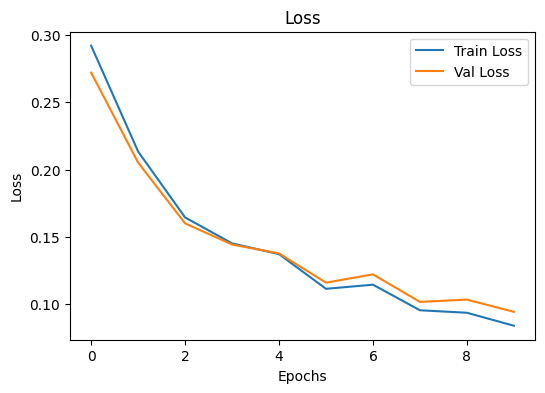

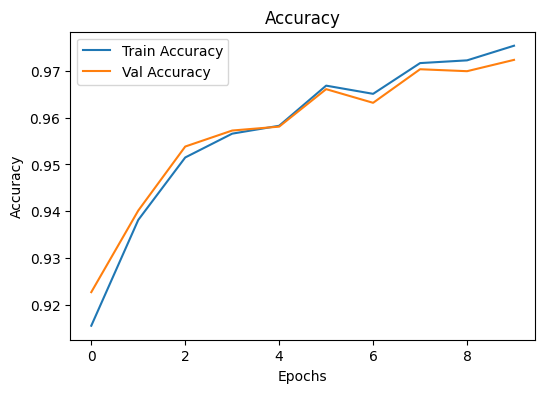

In [7]:

plt.figure(figsize=(6,4))
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["train_acc"], label="Train Accuracy")
plt.plot(hist["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
plt.show()


## 7) Evaluation & Example of Predictions


Test accuracy : 0.9749



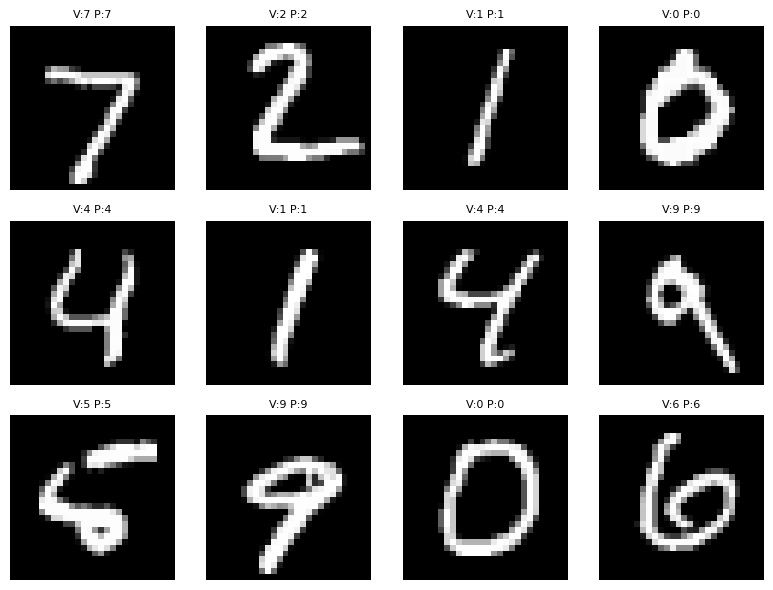

In [8]:

# Evaluation of accuracy
probs_te = softmax(forward_pass(x_test))
acc_te = accuracy(probs_te, y_test)
print(f"\nTest accuracy : {acc_te:.4f}\n")

# Example of Predictions
n = 12
imgs = x_test[:n]; labels = y_test[:n]
preds = probs_te[:n].argmax(axis=1)

fig, axes = plt.subplots(3, 4, figsize=(8,6))
for k, ax in enumerate(axes.flat):
    if k >= n:
        ax.axis('off'); continue
    ax.imshow(imgs[k].squeeze(), cmap='gray')
    ax.set_title(f"V:{labels[k]} P:{preds[k]}", fontsize=8)
    ax.axis('off')
plt.tight_layout(); plt.show()



 Misclassified: 251 / 10000 (2.51%)



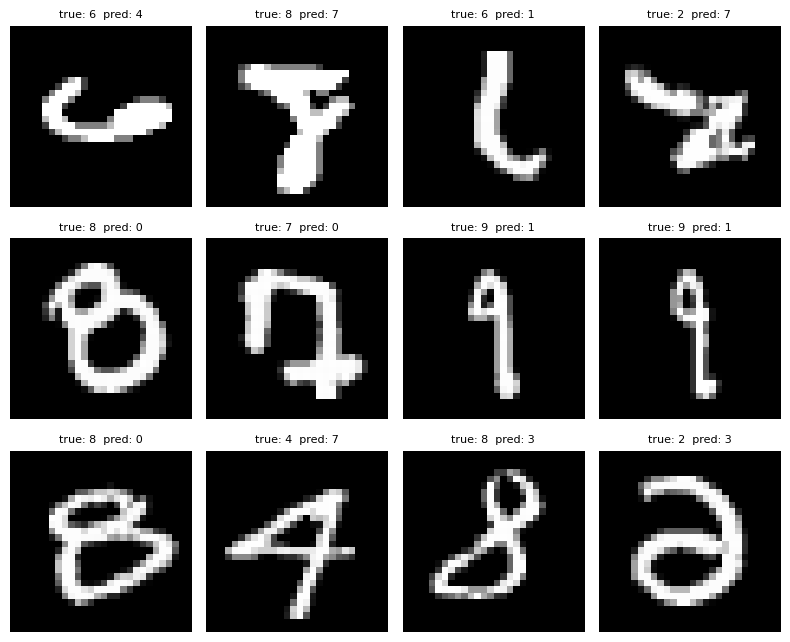

In [16]:
# Misclassified examples

preds = probs_te.argmax(axis=1)
N_preds = len(preds)

# Indices of misclassified samples
mis_idx = np.where(preds != y_test[:N_preds])[0]
print(f"\n Misclassified: {mis_idx.size} / {N_preds} "
      f"({mis_idx.size / max(1, N_preds):.2%})\n")

# Show the most confident mistakes first
wrong_conf = probs_te[mis_idx, preds[mis_idx]]  # confidence of the (wrong) predicted class
order = np.argsort(-wrong_conf)                 # descending conf
mis_idx = mis_idx[order]

# Display max 12 examples
n = min(12, mis_idx.size)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(8, 2.2*rows))
axes = np.atleast_1d(axes).ravel()

for k in range(rows * cols):
    ax = axes[k]
    if k < n:
        idx = mis_idx[k]
        img = x_test[idx].squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"true: {y_test[idx]}  pred: {preds[idx]}", fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()